In [14]:
import torch
import torch.nn as nn
import torch.distributions as td
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

## Environment
Here, we are going to use a simple environment to test our model. Suppose we control a particle (represented by white rectangular) that moves in a 2D plane. We can directly control the velocity of the particle along $x$ and $y$ axis. The task is to control the particle moving towards a goal position (represented by red rectangular) at the center of the plane (see video below). 

<img src="./particle_sys_gif.gif" width=200 height=200 />

Now, assume we can not directly observe the position of the particle and the goal, but we can access to some visual observation that is represented as images (see figure below).

<img src="./particle_sys.png" width=150 height=150 />

Now we are going to learn a state space model of this environment. Given the learnt model, we will be able to forward simulate trajectoris in latent space and plan some actions that minimize the distance to the goal position. 

In [15]:
class ParticleEnv:
    def __init__(self):
        self.state = np.array([0, 0])
        self.goal_state = np.array([0.5, 0.5])

        self.action_scale = 0.025
        self.step_count = 0

    def reset(self):
        self.step_count = 0
        self.state = 0.8 * (np.random.rand(2) - 0.5) + 0.5

        reward = -np.sqrt(np.square(self.state - self.goal_state).sum())
        state_image = self.generate_image()

        # potential_goal_states = [[0.0, 0.0], [0.9, 0.9], [0.9, 0.0], [0.0, 0.9]]
        # self.goal_state = np.array(potential_goal_states[random.choice([0, 1, 2, 3])])
        return self.state.copy(), state_image, reward

    def step(self, action):
        self.state += action * self.action_scale
        self.state = np.clip(self.state, a_min=0.0, a_max=1.0)

        reward = -np.sqrt(np.square(self.state - self.goal_state).sum())

        if np.sqrt(np.square(self.state - self.goal_state).sum()) < 0.01:
            done = True
        else:
            done = False

        state_image = self.generate_image()
        self.step_count += 1

        if self.step_count > 10:
            done = True
        return self.state.copy(), state_image, reward, done

    def generate_image(self):
        resolution = 32
        radius = 3
        image_canvas = np.zeros(shape=[3, resolution, resolution])

        pixel_x = int(self.state[0].item() * (resolution - 1))
        pixel_y = int(self.state[1].item() * (resolution - 1))

        for i in range(radius):
            for j in range(radius):
                image_canvas[:, np.clip(pixel_x + i, 0, resolution - 1), np.clip(pixel_y + j, 0, resolution - 1)] = 1.0
                image_canvas[:, np.clip(pixel_x - i, 0, resolution - 1), np.clip(pixel_y - j, 0, resolution - 1)] = 1.0
                image_canvas[:, np.clip(pixel_x + i, 0, resolution - 1), np.clip(pixel_y - j, 0, resolution - 1)] = 1.0
                image_canvas[:, np.clip(pixel_x - i, 0, resolution - 1), np.clip(pixel_y + j, 0, resolution - 1)] = 1.0

        pixel_x = int(self.goal_state[0].item() * (resolution - 1))
        pixel_y = int(self.goal_state[1].item() * (resolution - 1))

        for i in range(radius):
            for j in range(radius):
                image_canvas[0, np.clip(pixel_x + i, 0, resolution - 1), np.clip(pixel_y + j, 0, resolution - 1)] = 1.0
                image_canvas[0, np.clip(pixel_x - i, 0, resolution - 1), np.clip(pixel_y - j, 0, resolution - 1)] = 1.0
                image_canvas[0, np.clip(pixel_x + i, 0, resolution - 1), np.clip(pixel_y - j, 0, resolution - 1)] = 1.0
                image_canvas[0, np.clip(pixel_x - i, 0, resolution - 1), np.clip(pixel_y + j, 0, resolution - 1)] = 1.0

        return image_canvas

Here, we define a ReplayBuffer to collect data when interacting with the environment. The ReplayBuffer will record the visual observations (images), actions, reward (negative distance to the goal) and terminal flag at each time step. We also define some neural network template that will be used later. 

In [16]:
class ReplayBuffer(object):
    """Buffer to store and replay environment transitions."""

    def __init__(self, obs_shape, action_shape, reward_shape, capacity, batch_size, length, device='cpu'):
        self.capacity = capacity
        self.batch_size = batch_size
        self.length = length
        self.device = device
        # Initialize all the buffers
        self.obs_buffer = np.empty(shape=(capacity, *obs_shape), dtype=np.float32)
        self.action_buffer = np.empty(shape=(capacity, *action_shape), dtype=np.float32)
        self.reward_buffer = np.empty(shape=(capacity, *reward_shape), dtype=np.float32)
        self.done_buffer = np.empty(shape=(capacity, *reward_shape), dtype=np.float32)
        self.idx = 0

    def add(self, obs, action, reward, done):
        if self.idx < self.capacity:
            self.obs_buffer[self.idx] = obs
            self.action_buffer[self.idx] = action
            self.reward_buffer[self.idx] = reward
            self.done_buffer[self.idx] = done
            self.idx += 1
        else:
            self.obs_buffer = self.obs_buffer[1:]
            self.obs_buffer = np.append(self.obs_buffer,
                                        obs.reshape((1, obs.shape[0], obs.shape[1], obs.shape[2])),
                                        axis=0)
            self.action_buffer = self.action_buffer[1:]
            self.action_buffer = np.append(self.action_buffer,
                                           action.reshape((1, action.shape[0])),
                                           axis=0)
            self.reward_buffer = self.reward_buffer[1:]
            self.reward_buffer = np.append(self.reward_buffer,
                                           reward.reshape((1, 1)),
                                           axis=0)
            self.done_buffer = self.done_buffer[1:]
            self.done_buffer = np.append(self.done_buffer,
                                         done.reshape((1, done.shape[0])),
                                         axis=0)

    def sample(self):
        idxs = np.random.randint(
            0, self.capacity - self.length + 1 if self.idx == self.capacity else self.idx - self.length + 1,
            size=self.batch_size)
        obses = torch.as_tensor(self.obs_buffer[idxs], device=self.device).unsqueeze(1).float()
        actions = torch.as_tensor(self.action_buffer[idxs], device=self.device).unsqueeze(1).float()
        rewards = torch.as_tensor(self.reward_buffer[idxs], device=self.device).unsqueeze(1).float()
        dones = torch.as_tensor(self.done_buffer[idxs], device=self.device).unsqueeze(1).float()

        for i in range(1, self.length):
            next_obses = torch.as_tensor(self.obs_buffer[idxs + i], device=self.device).unsqueeze(1).float()
            next_actions = torch.as_tensor(self.action_buffer[idxs + i], device=self.device).unsqueeze(1).float()
            next_rewards = torch.as_tensor(self.reward_buffer[idxs + i], device=self.device).unsqueeze(1).float()
            next_dones = torch.as_tensor(self.done_buffer[idxs + i], device=self.device).unsqueeze(1).float()
            obses = torch.cat((obses, next_obses), 1)
            actions = torch.cat((actions, next_actions), 1)
            rewards = torch.cat((rewards, next_rewards), 1)
            dones = torch.cat((dones, next_dones), 1)

        return obses, actions, rewards, dones


class CNNDenseModel(nn.Module):
    def __init__(self, embed_dim: int, layers: int, h_dim: int,
                 activation=nn.ReLU, min=1e-4, max=10.0):
        super().__init__()
        self._embed_size = embed_dim
        self._layers = layers
        self._hidden_size = h_dim
        self.activation = activation
        self.model = self.build_model()
        self.soft_plus = nn.Softplus()
        self._min = min
        self._max = max
        self.conv_channels = 4

        self.conv_in = nn.Sequential(torch.nn.Conv2d(in_channels=3,
                                                     out_channels=self.conv_channels,
                                                     kernel_size=3,
                                                     stride=3))
        self.fc_out = self.build_model()

    def build_model(self):
        model = [nn.Linear(400, self._hidden_size)]
        model += [self.activation()]
        for i in range(self._layers - 1):
            model += [nn.Linear(self._hidden_size, self._hidden_size)]
            model += [self.activation()]
        model += [nn.Linear(self._hidden_size, self._embed_size)]
        return nn.Sequential(*model)

    def forward(self, obs_visual):
        x_visual = self.conv_in(obs_visual)
        x_visual = x_visual.contiguous()
        x_visual = x_visual.view(-1, self.conv_channels * 10 * 10)
        x = self.fc_out(x_visual)
        return x


class CNNDecoder(torch.nn.Module):
    def __init__(self, z_dim=10, h_dim=64):
        super().__init__()
        self.conv_channels = 4

        self.fc = nn.Sequential(torch.nn.Linear(z_dim, h_dim),
                                torch.nn.ReLU(),
                                torch.nn.Linear(h_dim, self.conv_channels * 10 * 10))
        self.deconv = nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=self.conv_channels, out_channels=3, kernel_size=5, stride=3))

    def forward(self, x):
        x = self.fc(x)
        h = x.view(-1, self.conv_channels, 10, 10)
        h = self.deconv(h)  # , output_size=(x.size(0), 3, 28, 28))
        return h


class DenseModelNormal(nn.Module):
    def __init__(self, feature_dim: int, output_shape: tuple, layers: int, h_dim: int, activation=nn.ELU,
                 min=1e-4, max=10.0):
        super().__init__()
        self._output_shape = output_shape
        self._layers = layers
        self._hidden_size = h_dim
        self.activation = activation
        # For adjusting pytorch to tensorflow
        self._feature_size = feature_dim
        # Defining the structure of the NN
        self.model = self.build_model()
        self.soft_plus = nn.Softplus()

        self._min = min
        self._max = max

    def build_model(self):
        model = [nn.Linear(self._feature_size, self._hidden_size)]
        model += [self.activation()]
        for i in range(self._layers - 1):
            model += [nn.Linear(self._hidden_size, self._hidden_size)]
            model += [self.activation()]
        model += [nn.Linear(self._hidden_size, 2 * int(np.prod(self._output_shape)))]
        return nn.Sequential(*model)

    def forward(self, features):
        dist_inputs = self.model(features)
        reshaped_inputs_mean = torch.reshape(dist_inputs[..., :np.prod(self._output_shape)],
                                             features.shape[:-1] + self._output_shape)
        reshaped_inputs_std = torch.reshape(dist_inputs[..., np.prod(self._output_shape):],
                                            features.shape[:-1] + self._output_shape)

        reshaped_inputs_std = torch.clamp(self.soft_plus(reshaped_inputs_std), min=self._min, max=self._max)
        return td.independent.Independent(td.Normal(reshaped_inputs_mean, reshaped_inputs_std), len(self._output_shape))

## State Space Model
Here, we define our State Space Model (SSM). Intuitively, the SSM models an agent that is sequentially taking actions in a world and receiving rewards and visual observations. The observation $x_t$ at time $t$ visual observations are generated from the latent state $z_t$. The model assumes Markovian transitions where the next state is conditioned upon the current state and the action $a_t$ taken by the agent. Upon taking an action, the agent receives reward $r_t$. Given the graphical structure in the figure below, the SSM's joint distribution factorizes as:

<img src="./pgm.png" width=400 height=400 />

\begin{align}
    &p_\theta(x_{1:T},r_{1:T},z_{0:T},a_{1:T-1}) = \prod_{t=1}^{T} p_\theta(x_{t}|z_{t})p_\theta(r_{t}|z_{t})p_\theta(z_{t}|z_{t-1},a_{t-1})p_\psi(a_{t-1}|z_{t-1})p(z_0)
\end{align}

Each of the factorized distributions are modelled using nonlinear functions:

* Transitions: $p_\theta(z_{t}|z_{t-1},a_{t-1}) = p(z_{t}| f_\theta(z_{t-1},a_{t-1}))$
* Observations: $p_\theta(x_{t}|z_{t}) = p(x_{t}| d_\theta(z_{t})) $ 
* Rewards: $p_\theta(r_{t}|z_{t}) = p(r_{t}| r_\theta(z_{t})) $

where $f_\theta$, $d^m_\theta$, $r_\theta$, and $\pi_\psi$ are neural networks parameterized by $\theta$. Given nonlinearity of these factorized distributions, the posterior distribution $p(z_{1:T}|x_{1:T},a_{1:T-1})$ is intractable. Thus, we approximate it by 

$$p(z_{1:T}|x_{1:T},a_{1:T-1})\approx\hat{q}_{\phi}(z_{1:T}|x_{1:T},a_{1:T-1})=\prod_{t=2}^T q_\phi(z_{t}|g_\phi(x_{t}, z_{t-1}, a_{t-1}))p(z_1)$$

where $q_\phi$ is modeled as a Gaussian distribution and $g_\theta(x_{t}, z_{t-1}, a_{t-1})$ is a neural network parameterized by $\phi$, which is typically called inference network.

Given all these distributions and trajectories of the form $\tau = \left\{(x_{t}, a_{t}, r_{t})\right\}_{t=1}^{T}$ that samples from the ReplayBuffer, we seek to learn the parameters $\theta$ and $\phi$. Because maximum likelihood estimation is intractable in this setting, we optimize the evidence lower bound (ELBO) under the data distribution $p_d$ using a variational distribution $q$ over the latent state variables $z_t$ 

\begin{align}
\mathbb{E}_{p_d}[\mathrm{ELBO}] \leq \mathbb{E}_{p_d}[\log p_\theta(x_{1:T},r_{1:T}|a_{1:T-1})]
\end{align}

where 
\begin{align}
     \mathrm{ELBO} = & \sum_{t=1}^{T}\Big(\displaystyle  \mathop{\mathbb{E}}_{\hat{q}_{\phi}(z_{t})}\left[\log p_{\theta}(x_{t}|z_{t})\right] +\displaystyle\mathop{\mathbb{E}}_{\hat{q}_{\phi}(z_{t})}\left[\log p_{\theta}(r_{t}|z_{t})\right]  \nonumber\\
    &- \displaystyle\mathop{\mathbb{E}}_{\hat{q}_{\phi}(z_{t-1})}\left[\mathrm{KL}\left[\hat{q}_{\phi}(z_{t}) \| p_{\theta}(z_{t}|z_{t-1},a_{t-1})\right]\right]\Big)
\end{align}

In [17]:
class SequentialVAE(nn.Module):
    def __init__(self, z_dim=8, action_dim=2, embed_dim=32):
        super().__init__()
        self.image_embed_net = CNNDenseModel(embed_dim=embed_dim, h_dim=64, layers=2)
        self.inference_net = DenseModelNormal(feature_dim=embed_dim + z_dim + action_dim,
                                              output_shape=(z_dim,),
                                              layers=2,
                                              h_dim=32)

        self.transition_net = DenseModelNormal(feature_dim=z_dim + action_dim,
                                               output_shape=(z_dim,),
                                               layers=2,
                                               h_dim=32)

        self.emission_net = CNNDecoder(z_dim=z_dim, h_dim=32)
        self.reward_net = DenseModelNormal(feature_dim=z_dim,
                                           output_shape=(1,),
                                           layers=2,
                                           h_dim=32)

        self.z_dim = z_dim
        self.action_dim = action_dim

        self.optimizer = torch.optim.Adam(params=self.parameters(), lr=0.002)

        self.anneal_factor = 2.0

    def get_z_post_dist(self, obs, z=None, action=None):

        obs_embed = self.image_embed_net(obs)

        if len(obs.shape) == 3:
            obs_embed = obs_embed[0]

        if z is None:
            z = torch.zeros(obs_embed.shape[:-1] + (self.z_dim,))

        if action is None:
            action = torch.zeros(obs_embed.shape[:-1] + (self.action_dim,))
        z_post_dist = self.inference_net(torch.cat([obs_embed, z, action], dim=-1))
        return z_post_dist

    def cross_entropy_planning(self, z):
        horizon = 4
        sample_size = 100
        discount_factor = 0.8

        action_samples = torch.randint(low=-1, high=2, size=(sample_size, horizon, self.action_dim))

        accumulated_reward = torch.zeros((1, 1))
        z_temp = z.clone().unsqueeze(0).repeat(sample_size, 1)
        for t in range(horizon):
            z_temp_dist = self.transition_net(torch.cat([z_temp, action_samples[:, t]], dim=-1))
            z_temp = z_temp_dist.mean

            reward = self.reward_net(z_temp).mean
            accumulated_reward = accumulated_reward + reward * (discount_factor ** t)

        opti_id = torch.argmax(accumulated_reward, dim=0)
        opti_action_sample = action_samples[opti_id.item()]
        return opti_action_sample[0]

    def learn(self, replay_buffer, episode_count):
        max_epoch = 200
        for i in range(max_epoch):
            obs, action, reward, done = replay_buffer.sample()

            batch_t = obs.shape[1]

            # get latent_state
            z_post_rsample = [[]] * batch_t
            z_post_mean = [[]] * batch_t
            z_post_std = [[]] * batch_t

            for t in range(batch_t):
                if t == 0:
                    z_post_dist = self.get_z_post_dist(obs[:, t])
                else:
                    z_post_dist = self.get_z_post_dist(obs[:, t], z_post_rsample[t - 1], action[:, t - 1])
                z_post_rsample[t] = z_post_dist.rsample()
                z_post_mean[t] = z_post_dist.mean
                z_post_std[t] = z_post_dist.stddev
            z_post_rsample = torch.stack(z_post_rsample, dim=1)
            z_post_mean = torch.stack(z_post_mean, dim=1)
            z_post_std = torch.stack(z_post_std, dim=1)

            z_trans_mean = [[]] * batch_t
            z_trans_std = [[]] * batch_t
            for t in range(batch_t):
                if t == 0:
                    z_trans_mean[t] = z_post_mean[:, t]
                    z_trans_std[t] = z_post_std[:, t]
                else:
                    z_trans_dist = self.transition_net(torch.cat([z_post_rsample[:, t - 1], action[:, t]], dim=-1))
                    z_trans_mean[t] = z_trans_dist.mean
                    z_trans_std[t] = z_trans_dist.stddev
            z_trans_mean = torch.stack(z_trans_mean, dim=1)
            z_trans_std = torch.stack(z_trans_std, dim=1)

            obs_rec = self.emission_net(z_post_rsample)
            obs_rec_loss = 100 * torch.square(obs_rec - obs.view(-1, 3, 32, 32)).mean()

            reward_dist = self.reward_net(z_post_mean.detach())
            reward_rec_loss = -reward_dist.log_prob(reward).mean()

            kl_loss = (z_trans_std.log() - z_post_std.log()
                       + (z_post_std.pow(2) + (z_trans_mean - z_post_mean).pow(2))
                       / (2 * z_trans_std.pow(2) + 1e-5) - 0.5).mean()

            self.optimizer.zero_grad()
            loss = obs_rec_loss + reward_rec_loss + 1.0 * torch.max(kl_loss, torch.ones(1) * self.anneal_factor)
            loss.backward()
            self.optimizer.step()

        self.anneal_factor = np.clip(self.anneal_factor * 0.9, 0.1, 10.0)

        print(
            f'{episode_count}: obs_loss:{obs_rec_loss.item()}, reward_loss:{reward_rec_loss.item()}, kl_loss:{kl_loss.item()}')

## Main Loop
Without loss of generality, we begin at time-step $t-1$ where we have a sample of $z_{t-1}$ and taken a action $a_{t-1}$. At time step $t$, we first recieve an visual observation $x_t$ and reward $r_t$. Then,we pass $z_{t-1}$, $a_{t-1}$ and $x_t$ into the variational distribution $q_\phi(z_t|z_{t-1}, a_{t-1}, x_t)$ and sample a $z_t$ from $q_\phi$. Given the sample $z_t$, we optimize the following objective:

\begin{align}
\mathrm{argmax}_{a_{t:t+H-1}} \ \ J = \mathrm{E}_{p(z_{t+1:t+H}\ \ \ \ |a_{t:t+H-1}\ \ \ \ ,z_t)}\left[\sum_{k=t+1}^{t+H} {\gamma^tr(z_t)} \right]
\end{align}

where $p(z_{t+1:t+H}|a_{t:t+H-1},z_t)=\prod_{k=t+1}^{t+H}p_\theta(z_{k}|f_\theta(z_{k-1},a_{k-1}))$ We choose action $a_t$ to execute and replan at each time step. After that,environment fowards to the $t+1$.

In [18]:
def main(test=False):
    env = ParticleEnv()
    replay_buffer = ReplayBuffer(obs_shape=(3, 32, 32),
                                 action_shape=(2,),
                                 reward_shape=(1,),
                                 capacity=1000,
                                 batch_size=50,
                                 length=10)

    model = SequentialVAE(z_dim=5, action_dim=2)
    if test:
        model.load_state_dict(torch.load('./model.pt'))

    model.eval()
    _, obs, reward = env.reset()

    z_post_mean = None
    action = None

    max_episode = 100
    episode_count = 0
    episode_data_size = 200

    visualize_freq = 5


    ims = []
    fig, ax = plt.subplots()
    while True:
        avg_reward = 0.0
        for i in range(episode_data_size):
            z_post_mean = model.get_z_post_dist(torch.as_tensor(obs).float(), z_post_mean, action).mean

            action = model.cross_entropy_planning(z_post_mean)
            _, obs, reward, done = env.step(action.detach().numpy())

            avg_reward += reward
            visualize_image = obs.transpose((1, 2, 0))
            if episode_count % visualize_freq == 0:

                im = ax.imshow(visualize_image, animated=True)
                ims.append([im])

            replay_buffer.add(obs, action, reward, np.array([done]))

            if done:
                _, obs, reward = env.reset()
                z_post_mean = None
                action = None

        avg_reward /= episode_data_size
        print(f'avg_reward:{avg_reward}')

        if episode_count % visualize_freq == 0:
            ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                            repeat_delay=1000)
            writergif = animation.PillowWriter(fps=30)

            if test:
                file_name = f'./test_episode_{episode_count}.gif'
            else:
                file_name = f'./episode_{episode_count}.gif'
            ani.save(file_name, writer=writergif)
            ims.clear()

        if not test:
            # train model using collected data
            model.train()
            model.learn(replay_buffer, episode_count)
            model.eval()
            torch.save(model.state_dict(), './model.pt')

        episode_count += 1
        if episode_count > max_episode:
            break

avg_reward:-0.38256699793870363
0: obs_loss:1.7802104949951172, reward_loss:-0.9428811073303223, kl_loss:1.165176272392273
avg_reward:-0.38967081489607147
1: obs_loss:1.4218614101409912, reward_loss:-0.91034996509552, kl_loss:1.3015347719192505
avg_reward:-0.3273090250466683
2: obs_loss:1.2923067808151245, reward_loss:-1.0265989303588867, kl_loss:1.5137642621994019
avg_reward:-0.32336307055400837
3: obs_loss:1.2721248865127563, reward_loss:-1.1582387685775757, kl_loss:1.1997597217559814
avg_reward:-0.23971112899905983
4: obs_loss:1.1961008310317993, reward_loss:-1.254366397857666, kl_loss:1.2024930715560913
avg_reward:-0.3180173344662827
5: obs_loss:1.1998205184936523, reward_loss:-1.3241875171661377, kl_loss:1.0794649124145508
avg_reward:-0.36725186314524655
6: obs_loss:1.210439682006836, reward_loss:-1.334482192993164, kl_loss:0.9939008951187134
avg_reward:-0.35315265823084063
7: obs_loss:1.206045389175415, reward_loss:-1.3584407567977905, kl_loss:0.9151557683944702
avg_reward:-0.236

avg_reward:-0.2256977990268651
66: obs_loss:0.8210762143135071, reward_loss:-2.788252353668213, kl_loss:0.21383191645145416
avg_reward:-0.2367741315440081
67: obs_loss:0.8912028074264526, reward_loss:-2.7393760681152344, kl_loss:0.20012764632701874
avg_reward:-0.16906261216995286
68: obs_loss:0.8296284079551697, reward_loss:-2.740994453430176, kl_loss:0.20192988216876984
avg_reward:-0.19526436500287525
69: obs_loss:0.8764277100563049, reward_loss:-2.4745583534240723, kl_loss:0.20335181057453156
avg_reward:-0.19017351772996452
70: obs_loss:0.8971287608146667, reward_loss:-2.3109493255615234, kl_loss:0.17949500679969788
avg_reward:-0.18975638238080514
71: obs_loss:0.7982034087181091, reward_loss:-2.648041248321533, kl_loss:0.19071432948112488
avg_reward:-0.15279821175929575
72: obs_loss:0.7979451417922974, reward_loss:-2.7471089363098145, kl_loss:0.1753120869398117
avg_reward:-0.19529785182298376
73: obs_loss:0.7682246565818787, reward_loss:-2.911562442779541, kl_loss:0.1936962753534317


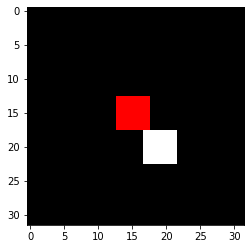

In [19]:
main(False)